In [1]:
import os
import bye_cycle
import tensorflow as tf
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
from tqdm import tqdm
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from beep.structure.cli import auto_load_processed
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
input_window_size = 50
output_window_size = 50
pkl_f_l_filename = f'CACHED_DATA/pickled_cycle_windows/LFP/fearures_labels_inputs_window_{input_window_size}_outputs_window_{output_window_size}.pkl'
with open(pkl_f_l_filename, 'rb') as f:
    [cell_features, cell_labels] = pkl.load(f)  

In [3]:
prepared_data = list(zip(cell_features, cell_labels))

random.seed(0)
shuffled_indices = list(range(len(prepared_data)))
random.shuffle(prepared_data)
# prepared_data = prepared_data[shuffled_indices]

train_size = 0.9
val_size = 0.2
N_train = int(train_size *len(prepared_data))
N_val = int(val_size * N_train)
train_cells = prepared_data[:N_train]
test_cells = prepared_data[N_train:]

val_cells = train_cells[:N_val]
train_cells = train_cells[N_val:]
print(f'Train size:{len(train_cells)}\n'+ f'Validation size:{len(val_cells)}\n'+ f'Test size:{len(test_cells)}\n' + f'Total cells: {len(train_cells)+len(test_cells)+len(val_cells)}')

Train size:100
Validation size:25
Test size:14
Total cells: 139


In [4]:
# prepare train, val and test dat
random.seed(0)

X_train = [x for xs in train_cells for x in xs[0]]
Y_train = [x for xs in train_cells for x in xs[1]]
dc_train, slopes_train = bye_cycle.make_label_arrays(Y_train)
X_train_time_series, X_train_dt = bye_cycle.make_feature_arrays(X_train)

indices = list(range(len(X_train_time_series)))
random.shuffle(indices)
X_train_time_series = X_train_time_series[indices]
X_train_dt = X_train_dt[indices]


slopes_train = slopes_train[indices]
dc_train = dc_train[indices]


X_val = [x for xs in val_cells for x in xs[0]]
Y_val = [x for xs in val_cells for x in xs[1]]
dc_val, slopes_val = bye_cycle.make_label_arrays(Y_val)
X_val_time_series, X_val_dt = bye_cycle.make_feature_arrays(X_val)

X_test = [x for xs in test_cells for x in xs[0]]
Y_test = [x for xs in test_cells for x in xs[1]]
dc_test, slopes_test = bye_cycle.make_label_arrays(Y_test)
X_test_time_series, X_test_dt = bye_cycle.make_feature_arrays(X_test)

f_scaler, scaled_X_train_time_series = bye_cycle.scale(X_train_time_series[...,1:])
_ , scaled_X_val_time_series = bye_cycle.scale(X_val_time_series[...,1:], f_scaler)
_ , scaled_X_test_time_series = bye_cycle.scale(X_test_time_series[...,1:], f_scaler)

l_scaler, scaled_slopes_train = bye_cycle.scale(slopes_train)
_ , scaled_slopes_val = bye_cycle.scale(slopes_val, l_scaler)
_ , scaled_slopes_test = bye_cycle.scale(slopes_test, l_scaler)

In [11]:
hyper_params = bye_cycle.DegredationModelHyperParams(reg_strength=0)

model = bye_cycle.DegredationModel(hyper_params)
model.compile()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 100, 2)]      0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 1, 32)        6432      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 1, 32)        0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 32)           0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 64)           16640     
 l)                                                          

In [6]:
model.fit(scaled_X_train_time_series, scaled_slopes_train,
          validation_data=(scaled_X_val_time_series, scaled_slopes_val), verbose=0, epochs=200)

Text(0.5, 0, 'Epochs')

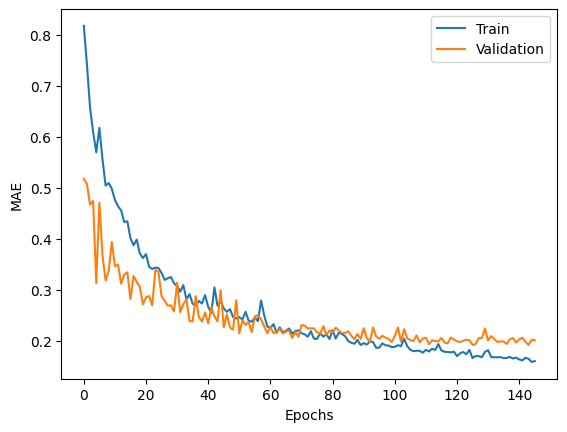

In [7]:
plt.figure(dpi=100, facecolor='white')
plt.plot(model.history.history['loss'], color='C0', label='Train')
plt.plot(model.history.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')

In [8]:
slope_mae = model.evaluate(scaled_X_test_time_series, scaled_slopes_test)
Y_hat_test_scaled = model.predict(scaled_X_test_time_series)
Y_hat_test = l_scaler.inverse_transform(Y_hat_test_scaled)

6/6 [==============================] - 1s 13ms/step


(0.0, 110.0)

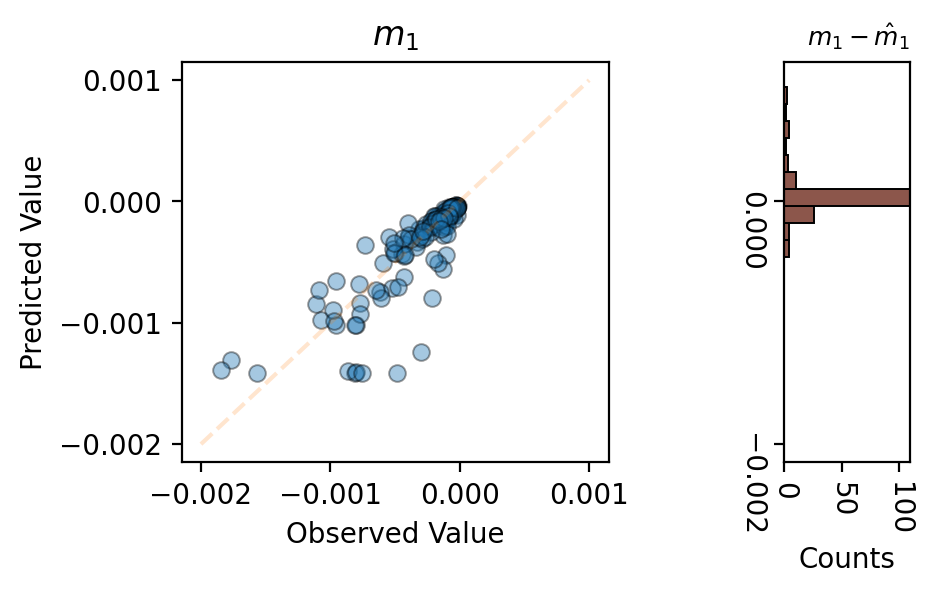

In [9]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(5,5, hspace=5)
fig = plt.figure(figsize=(4.7, 5), dpi=200, facecolor='white')
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,4])

ax_joint.scatter(slopes_test[:,0], Y_hat_test[:,0], alpha=0.4, edgecolor='k', linewidth=0.7)
ax_joint.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
ax_joint.set_title(r'$m_1$')
ax_joint.set_xlabel('Observed Value')
ax_joint.set_ylabel('Predicted Value')
ax_joint.locator_params(nbins=4)
ymin, ymax = ax_joint.get_ylim()

err = slopes_test[:,0] - Y_hat_test[:,0]
ax_marg_y.hist(err, bins=10, orientation="horizontal", edgecolor='black', linewidth=0.7, color ='C5');
ax_marg_y.set_xlabel('Counts')
ax_marg_y.set_title(r'$m_1 - \hat{m}_1$', fontsize=9, loc='right')

ax_marg_y.tick_params(rotation=-90)
ax_marg_y.locator_params(nbins=3)
ax_marg_y.set_ylim([ymin, ymax])
ax_marg_y.set_xlim([0, 110])

(-0.00215, 0.00115)

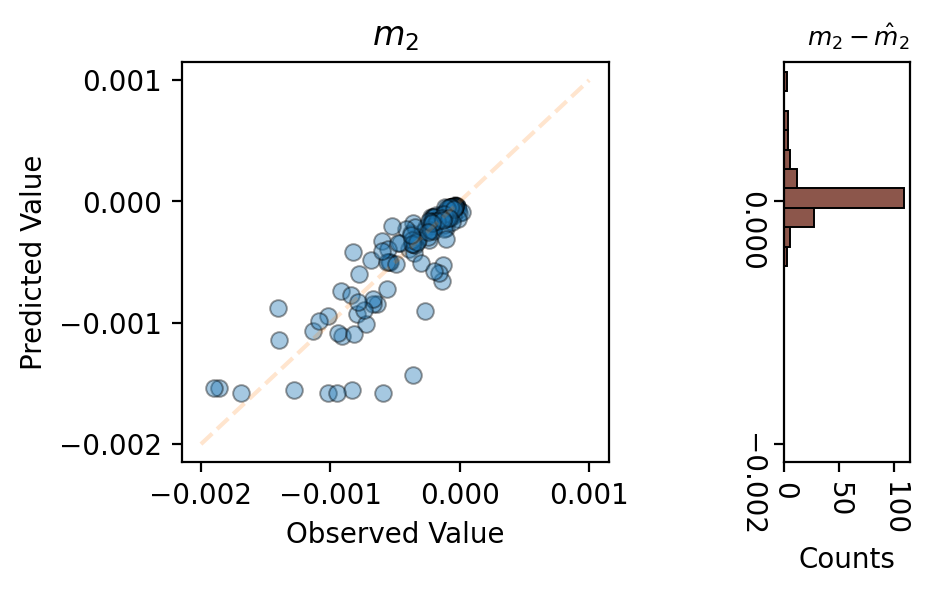

In [10]:
gs = GridSpec(5,5, hspace=5)
fig = plt.figure(figsize=(4.7, 5), dpi=200, facecolor='white')
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,4])

ax_joint.scatter(slopes_test[:,1], Y_hat_test[:,1], alpha=0.4, edgecolor='k', linewidth=0.7)
ax_joint.plot([-0.002,0.001], [-0.002,0.001], color='C1', alpha=0.2, linestyle='--')
ax_joint.set_title(r'$m_2$')
ax_joint.set_xlabel('Observed Value')
ax_joint.set_ylabel('Predicted Value')
ax_joint.locator_params(nbins=4)
ymin, ymax = ax_joint.get_ylim()

err = slopes_test[:,1] - Y_hat_test[:,1]
ax_marg_y.hist(err, bins=10, orientation="horizontal", edgecolor='black', linewidth=0.7, color ='C5');
ax_marg_y.set_xlabel('Counts')
ax_marg_y.set_title(r'$m_2 - \hat{m}_2$', fontsize=9, loc='right')

ax_marg_y.tick_params(rotation=-90)
ax_marg_y.locator_params(nbins=3)
ax_marg_y.set_ylim([ymin, ymax])
